In [2]:
from model import interaction_model

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import glob
import argparse
import os
import seaborn as sns
import matplotlib

---

### Plot settings

In [8]:
plt.rcParams['figure.figsize'] = (10, 6)  
plt.rcParams['font.size'] = 16  
plt.rcParams['axes.titlesize'] = 18  
plt.rcParams['axes.labelsize'] = 16  
plt.rcParams['xtick.labelsize'] = 14  
plt.rcParams['ytick.labelsize'] = 14  
plt.rcParams['legend.fontsize'] = 14 
plt.rcParams['figure.titlesize'] = 18
matplotlib.rcParams['savefig.directory'] = 'img'

---

In [ ]:
# パラメータ設定
gamma_values = np.linspace(0, 1, 11)  # Gammaを0から1まで10ステップで変更
num_iterations = 10 # 各gammaについての繰り返し回数
num_nodes = 1000  # エージェント数
h, n, c, m = 32, 6, 2, 3  # モデルパラメータ
infection_rate = 0.15
initial_infected_ratio = 0.2

# 結果保存用リスト
gamma_list = []
psi_list = []

# シミュレーション実行
for gamma in gamma_values:
    for i in range(num_iterations):  # 各gammaについて複数の試行
        print(f"Running gamma={gamma:.2f}, iteration={i+1}")
        
        # モデル初期化
        model = interaction_model(
            gamma=gamma,
            h = h,
            n = n,
            m = m,
            c = c
        )
        model.reset()
        
        model.run(50000)
        # Sorting値を計算
        psi = model.calculate_sorting()
        
        # gammaとpsiをリストに保存
        gamma_list.append(gamma)
        psi_list.append(psi)

# 結果をプロット
plt.figure(figsize=(10, 6))
plt.scatter(gamma_list, psi_list, alpha=0.7, s=20)
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\Psi$")
# plt.title(f"Sorting Value (Psi) vs. Gamma\n(h={h}, n={n}, c={c}, m={m}, infection_rate={infection_rate})")

# plt.grid()

# ファイル名を自動生成して保存
output_filename = f"img/.png"
plt.savefig(output_filename)
plt.show()


---

### Data loading and processing

In [4]:
def load_and_process_data(fp):
    """
    Load and process data from files matching the given file pattern,
    organise the data, and return it as a pandas DataFrame.

    Parameters:
        fp (str): File path pattern to match the files to be loaded.

    Returns:
        pd.DataFrame: A DataFrame containing the organised data.
    """
    # Get the list of files matching the pattern
    file_list = glob.glob(fp)

    # Initialize a list to store the data
    data = []

    # Process each file
    for file in file_list:
        # Load data from the file
        loaded_data = np.load(file, allow_pickle=True).item()

        # Extract results for each gamma
        gamma = loaded_data['gamma']
        all_psi = loaded_data['psi']
        all_infected = loaded_data['infected']
        all_aware = loaded_data['aware']
        mean_psi = loaded_data['mean_psi']
        mean_infected = loaded_data['mean_infected']
        mean_aware = loaded_data['mean_aware']

        # Add individual data to the list
        for psi, infected, aware in zip(all_psi, all_infected, all_aware):
            data.append({
                "gamma": gamma,
                "psi": psi,
                "aware": aware,
                "infected": infected
            })

        # Add mean values (optional)
        data.append({
            "gamma": gamma,
            "psi": mean_psi,
            "aware": mean_aware,
            "infected": mean_infected,
            "type": "mean"  # For distinction
        })

    # Convert the list to a DataFrame and return it
    return pd.DataFrame(data)

In [5]:
high_fp = "data/high_infection_rate/*.npy"
high_df = load_and_process_data(high_fp)
high_df_mean = high_df[high_df.get("type") == "mean"]

low_fp = "data/low_infection_rate/*.npy"
low_df = load_and_process_data(low_fp)
low_df_mean = low_df[low_df.get("type") == "mean"]

---

### Scatter plots

In [16]:
def my_scatter(df, x_variable, y_variable, x_label, y_label, output_path, x_log_scale=False, y_log_scale=False):
    """
    Create a scatter plot of `x_variable` vs `y_variable` with colors representing `gamma`,
    optionally applying logarithmic scales to axes.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data to plot.
        x_variable (str): Column name in `df` for the x-axis.
        y_variable (str): Column name in `df` for the y-axis.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        output_path (str): Path to save the output plot (without extension).
        x_log_scale (bool): Whether to use logarithmic scale for the x-axis.
        y_log_scale (bool): Whether to use logarithmic scale for the y-axis.

    Returns:
        None
    """
    # Set the colormap
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=df["gamma"].min(), vmax=df["gamma"].max())

    # Log-transform variables for correlation if scales are logarithmic
    x_data = np.log10(df[x_variable]) if x_log_scale else df[x_variable]
    y_data = np.log10(df[y_variable]) if y_log_scale else df[y_variable]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(df[x_variable], df[y_variable] / 1000, c=df["gamma"], cmap=cmap, norm=norm, s=60)

    # Calculate and print the correlation coefficient
    correlation = x_data.corr(y_data)
    print(f"Correlation Coefficient of {x_variable} and {y_variable} (log-adjusted if applicable): {correlation:.3f}")

    # Apply log scales if specified
    if x_log_scale:
        plt.xscale('log')
    if y_log_scale:
        plt.yscale('log')

    # Add a colorbar
    cbar = plt.colorbar(sc)
    cbar.set_label(r'$\gamma$', fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    # Set axis labels
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)

    # Add grid and adjust layout
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Save the plot
    plt.savefig(output_path + ".png")
    plt.show()

#### High infection rate case ($\gamma = 0.05, \mu = 0.01$)

Correlation Coefficient of psi and infected (log-adjusted if applicable): 0.761


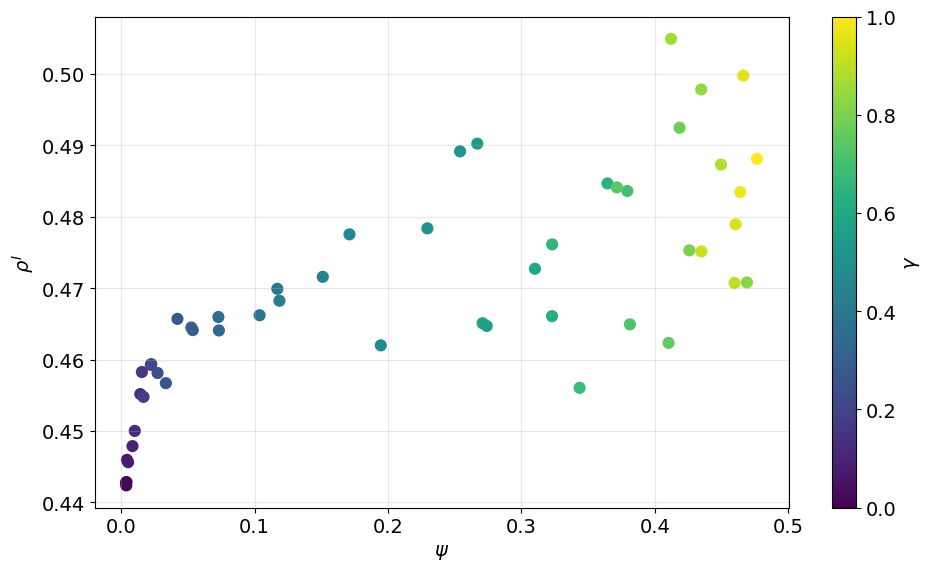

In [17]:
my_scatter(high_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/high_infection_rate/high_psi_rho_I", x_log_scale=False)

Correlation Coefficient of psi and infected (log-adjusted if applicable): 0.816


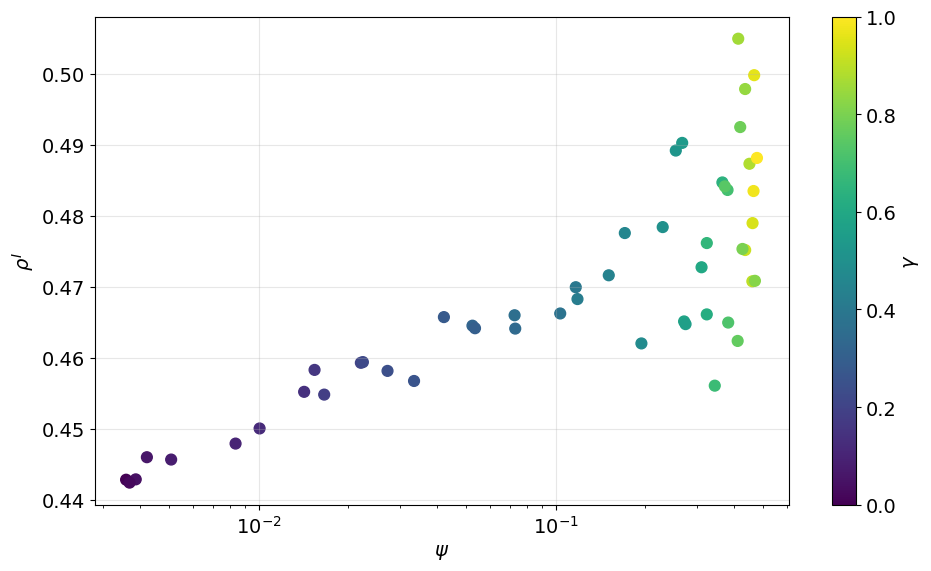

In [18]:
my_scatter(high_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/high_infection_rate/high_log_psi_rho_I", x_log_scale=True)

Correlation Coefficient of psi and aware (log-adjusted if applicable): 0.343


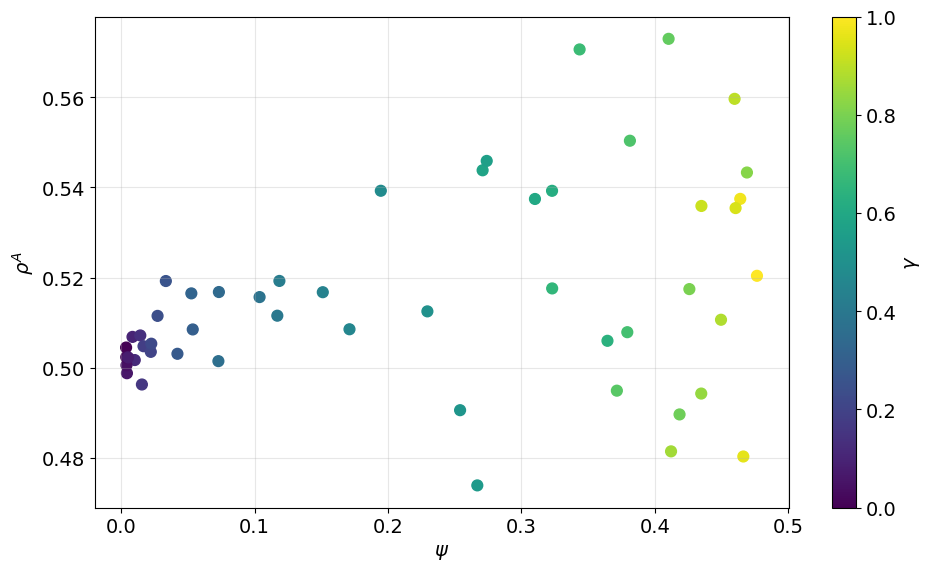

In [19]:
my_scatter(high_df_mean, "psi", "aware", r"$\psi$" , r"$\rho^A$", "img/high_infection_rate/high_log_psi_rho_A", x_log_scale=False)

#### Low infection rate case ($\gamma = 0.005, \mu = 0.1$)

Correlation Coefficient of psi and infected (log-adjusted if applicable): -0.671


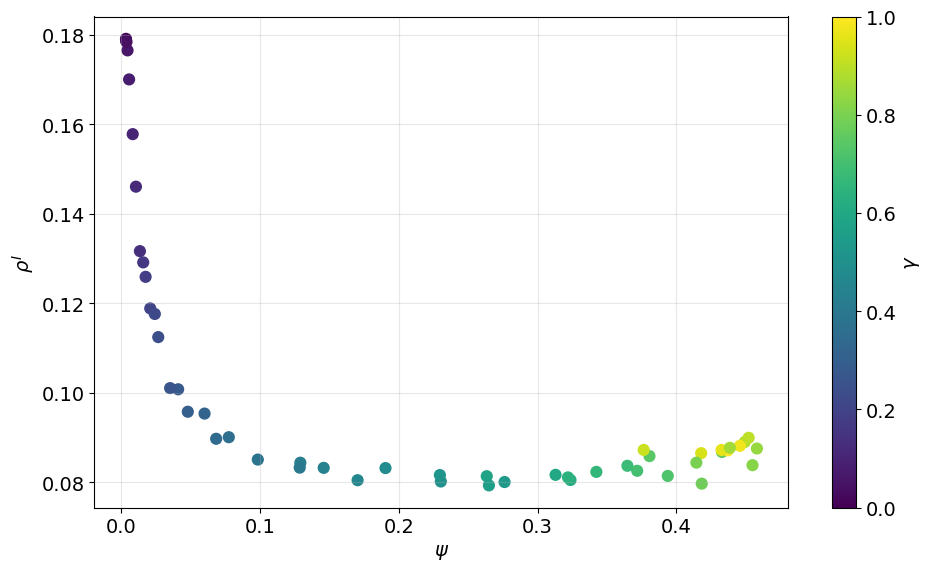

In [21]:
my_scatter(low_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/low_infection_rate/low_psi_rho_I", x_log_scale=False)

Correlation Coefficient of psi and infected (log-adjusted if applicable): -0.923


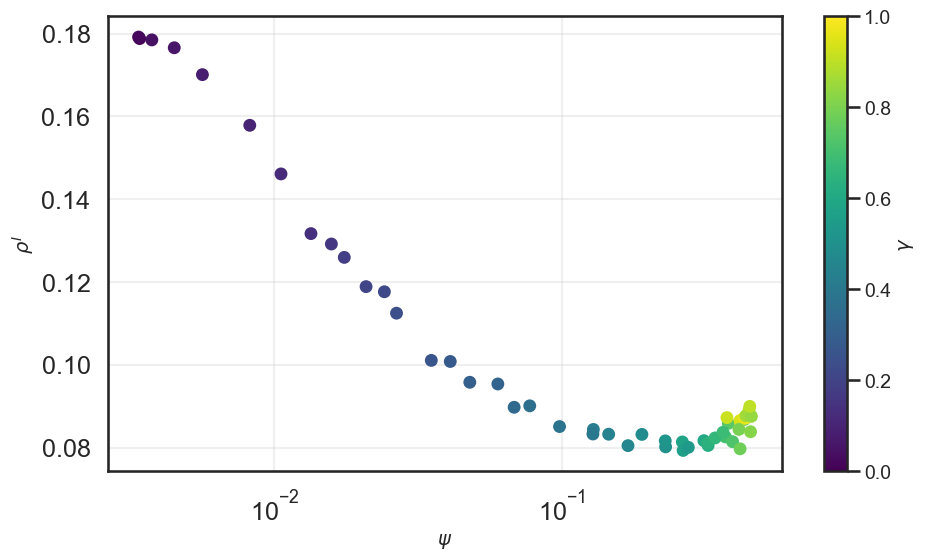

In [48]:
my_scatter(low_df_mean, "psi", "infected", r"$\psi$" , r"$\rho^I$", "img/low_infection_rate/low_log_psi_rho_I", x_log_scale=True)

Correlation Coefficient of psi and aware (log-adjusted if applicable): -0.963


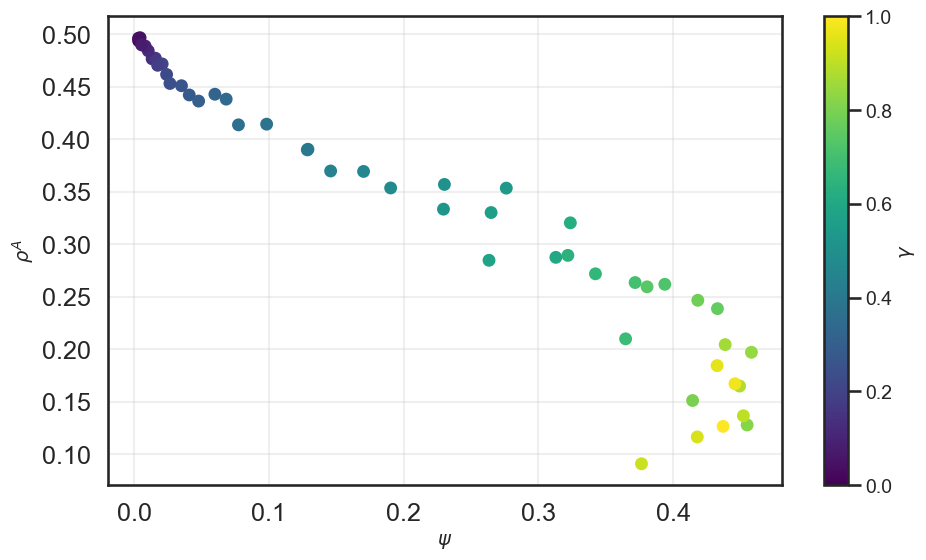

In [47]:
my_scatter(low_df_mean, "psi", "aware", r"$\psi$" , r"$\rho^A$", "img/low_infection_rate/low_log_psi_rho_A", x_log_scale=False)

---

### Heatmap

In [31]:
heatmap_data = np.load("data/heatmap/heatmap_data.npy")

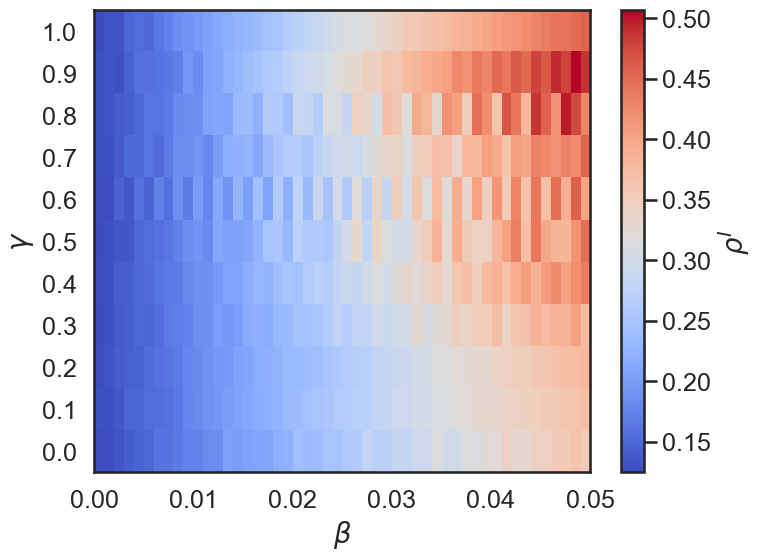

In [32]:
# Heatmapのプロット
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data / 1000, cmap="coolwarm", origin="lower", aspect="auto")
plt.colorbar(label="$\\rho^I$")

# Y軸の目盛りを調整
yticks = range(0, 11)  # 現在の目盛り位置 (0, 1, ..., 10)
yticks_labels = [f"{y / 10:.1f}" for y in yticks]  # 1/10 に変換したラベル
plt.yticks(ticks=yticks, labels=yticks_labels)

plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")

# X軸の調整
xticks = [0, 0.01, 0.02, 0.03, 0.04, 0.05]  # 元の xticks
xticks_shifted = [x - 0.0005 for x in xticks]  # 各値を少し左に移動
plt.xticks(
    ticks=[item * 1000 for item in xticks_shifted],
    labels=[f"{x:.2f}" for x in xticks]
)

# plt.title("Heatmap of Avg Infected Count")
plt.savefig(os.path.join("img/heatmap", "heatmap.png"))
plt.show()